In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Ellipse
import statistics as stat
from scipy.stats import vonmises, linregress
import math
#import pandas as pd
import pycircular as pyc
from functions_file import *
from scipy import interpolate
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
import scipy.special as sp
from functools import partial
import pandas as pd
import os

In [15]:
std = np.sqrt(2.37e-11)
print(std)

4.868264577855234e-06


In [2]:
#variables time
multiplying_factor_time = 10
T = 500*multiplying_factor_time #milliseconds, total time
T0 = 0 #ms
dt_position = 1 #ms
dt_spikewindow = 1 #ms

N_steps = int(np.floor(T/dt_position))
T_rounded = int(N_steps*dt_position)


#the number of time points is different from the number of steps. In the array (0,1,2) there are 2 steps and 3 points
 #if we wanna include in the count both the edges, because our starting point number is 0 (if it was 1 that is not necessary)
N_time_points = N_steps+1


#the function linspace creates a linearly spaced points INCLUDING both 0 and T_rounded, so the number of data points is N_steps + 1
T_vec0 = np.linspace(0, T_rounded, N_time_points)  


#reshaping the time vector 
T_vec = T_vec0.reshape(T_vec0.size, 1)

#print('T_vec: ', T_vec)
print('shape of the time vector:', T_vec.shape)



shape of the time vector: (5001, 1)


In [3]:
#variable initialization
sigma = 0.05  #[1/ms] #this would be in order to have a correlation time of about 20 ms, so the decoding time about 10 ms would be valid
mu_X = 0#0 #DRIFT #note: the velocity is directional +/-
#theta_X = 10 #threshold

X0 = mu_X #initial velocity equal to the mean velocity to avoid initial setting behaviour
X = np.zeros((N_time_points, 1))
dX = np.zeros((N_time_points, 1))
X[0] = X0

#
#seed = np.random.randint(0, 2**32)
seed = 70
np.random.seed(seed)



#simulation of white noise

diff_const = 2*np.pi*(10**(-3))*np.sqrt(2)*np.sqrt(sigma) #100*(10**(-9/2))/0.00063 #diffusion constant #
mean_wn, std_wn = 0, 1


#np.random.seed(seed_wn)
wnoise_value = diff_const*np.sqrt(dt_position)*np.random.normal(mean_wn, std_wn, size = N_time_points)



#Ornstein-Uhlenbeck process 
#((note that this t is not really the time but more the index indicator))

for t in range(T0, N_time_points-1):   #the minus 1 is necessary because an array (21,1) has row indeces that goes from 0 to 20

    dX[t] = sigma*(mu_X - X[t])*dt_position + wnoise_value[t]

    X[t + 1] = X[t] + dX[t]


print(np.mean(X))

#second time integration to derive HD
Y0 = 0     #head starting direction
Y = np.zeros((N_time_points, 1))
Y[0] = Y0       

for t in range(T0, N_time_points-1):
    Y[t+1] = Y[t] + X[t]*dt_position


#define the HD as a circular variable
theta_HD = Y % (2*np.pi) - np.pi #theta goes from -pi to pi
print(theta_HD.shape)




-0.00016976520124156893
(5001, 1)


3.141592653589793
9.424753499881504


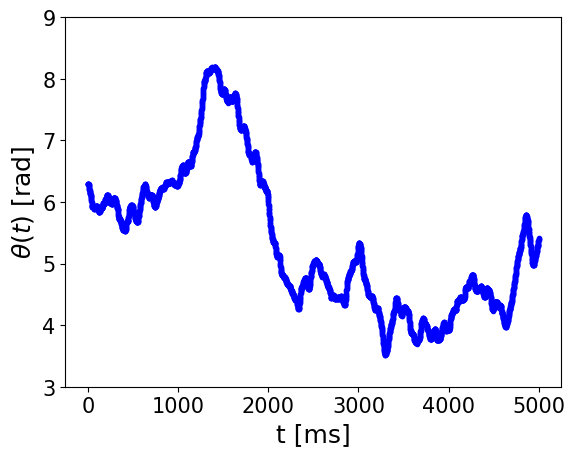

Var_X_exp:  4.658446718639796e-05
Var_X_theor:  3.947841760435743e-05


In [4]:
#finding the best limits for the graphs of the trajecory

min_thetaHD = np.min(theta_HD)
max_thetaHD = np.max(theta_HD)

bottom_limit = min_thetaHD + 2*np.pi 
up_limit= max_thetaHD + 2*np.pi 

print(bottom_limit)
print(up_limit)


fig, ax = plt.subplots(figsize=(6.4, 4.8)) #figsize=(25,8))  # Adjust the figure size (width, height in inches)

# Plot data with the same color
ax.plot(T_vec, theta_HD + np.pi, '.', color='blue', label=r'$\theta(t)$')
ax.plot(T_vec, theta_HD + 3* np.pi, '.', color='blue', label=r'$\theta(t) + 2\pi$')
ax.set_ylim([3,9])        #([bottom_limit, up_limit])
# Add labels, title, and legend
ax.set_xlabel("t [ms]", fontsize = 18)
ax.set_ylabel(r"$\theta(t)$ [rad]", fontsize = 18)
#ax.set_title('Angular Head Direction Over Time')
#ax.legend()
# Set font size for tick labels
ax.tick_params(axis='x', labelsize=15)  # x-axis tick labels
ax.tick_params(axis='y', labelsize=15)  # y-axis tick labels

# Show the plot
plt.show()

velocity_vector = X
#Variance of the OU process on X from the data

Var_X_exp = np.sum((X-np.mean(X))**2)/N_time_points
#note on denominator:
#   -sample variance -> divide for N_time_points -1
#   -population variance -> divide for N_time_points
#a sample is so e data from the population, which is consistent of way more datapoints. To avoid an underestimation of the population 
# variance, we divide for N_time_points -1 in the case of a sample, to get closer to the real variance. 

Var_X_theor = (diff_const**2)/(2*sigma)

print('Var_X_exp: ',Var_X_exp)
print('Var_X_theor: ', Var_X_theor)

In [5]:
percentage_var = Var_X_theor / Var_X_exp

print('Percentage error on variance exp/theor: ', percentage_var)

Percentage error on variance exp/theor:  0.8474588202628321


calcualting the autocorrelation between X values from the Onstein-Uhlenbeck process

Estimated decay time (tau): 20.71


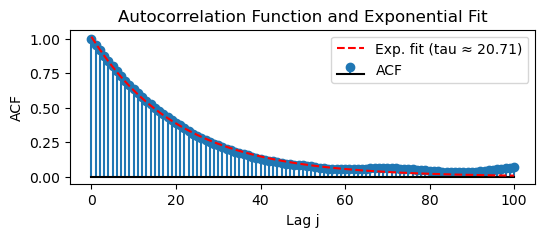

dt of autocorrelation [ms]:  20.714147974632354


In [6]:
#see ref https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html
acf_values = acf(X, adjusted=True, nlags=100, qstat=False, fft=True, alpha=None, bartlett_confint=True, missing='none')


# 3. Fit the exponential decay to the ACF values
lags = np.arange(len(acf_values))
params, _ = curve_fit(exponential_decay, lags, acf_values, p0=[5, 1])  # Initial guess for tau and A
#                                       lags[:40], acf_values[:40], p0=[5, 1]) considering only the first 40 points
# Extract the characteristic decay time (tau)
tau_autocorr = params[0]
print(f"Estimated decay time (tau): {tau_autocorr:.2f}")

# 4. Plot the ACF values and fitted exponential decay curve
plt.figure(figsize=(6,2))
plt.stem(lags, acf_values, linefmt="C0-", markerfmt="C0o", basefmt="k", label="ACF")
plt.plot(lags, exponential_decay(lags, *params), "r--", label=f"Exp. fit (tau ≈ {tau_autocorr:.2f})")
plt.xlabel("Lag j")
plt.ylabel("ACF")
plt.title("Autocorrelation Function and Exponential Fit")
plt.legend()
plt.show()

#dt for decoding 
dt_autocorr = tau_autocorr*dt_position 
print('dt of autocorrelation [ms]: ', dt_autocorr)

CASE OF MULTIPLE NEURONS

RUN FROM HERE after having changed the size of the time bins

In [2]:
N_neurons = 50 #numebr of neurons

#let's define the preferred head directions of all the neurons
#consider that we need to esclude one of the edges otherwise the first and last neuron would have the same preferred head direction
neuro_dir_tomod, step = np.linspace(0, 2*np.pi, (N_neurons + 1), retstep= True)#np.linspace(-np.pi, np.pi, (N_neurons + 1), retstep= True)
neuro_pref_dir_vector = neuro_dir_tomod[1:]

#random pref directions
#seed = np.random.randint(0, 2**32)
#np.random.seed(seed)
#neuro_pref_dir_vector = np.random.uniform(-np.pi, np.pi, 50)

#print('Preferred neurons head directions: ', neuro_pref_dir_vector)

print('first, middle, last pref dir:', 
      [neuro_pref_dir_vector[0], neuro_pref_dir_vector[len(neuro_pref_dir_vector) // 2 ] ,neuro_pref_dir_vector[-1]])

#print(len(neuro_pref_dir_vector) // 2 )
#dorting the neuron directions
neuro_pref_dir_vector = np.sort(neuro_pref_dir_vector)
neuro_pref_dir_vector = neuro_pref_dir_vector[::-1]

first, middle, last pref dir: [0.12566370614359174, 3.267256359733385, 6.283185307179586]


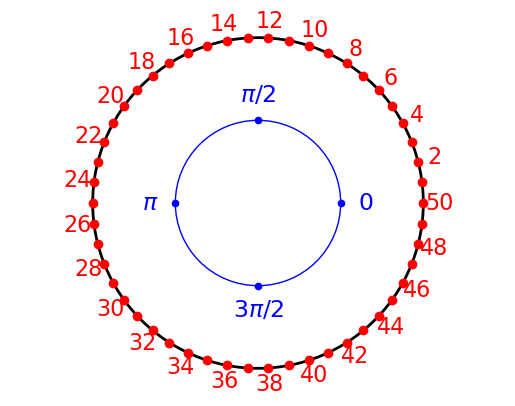

In [ ]:

angles = neuro_pref_dir_vector[::-1]  # Adjust angles

# Convert to Cartesian coordinates for plotting
x = np.cos(angles)
y = np.sin(angles)

# Circle parameters
radius = 1
radii_step = 2*np.pi / (50+1) # Step size in radians


# Create the existing figure
fig, ax = plt.subplots(figsize=(6.4, 4.8))
circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2)
ax.add_artist(circle)

# Plot all points and add labels (showing only even numbers with increased font size)
for i, (xi, yi) in enumerate(zip(x, y), start=1):
    ax.plot(xi, yi, 'ro')  # Plot all the points as red dots
    
    # Increase the font size by 40% for odd numbers
    if i % 2 == 0:  # Check if the index is even
        ax.text(xi * 1.1, yi * 1.1, str(i), color='red', fontsize=16, ha='center', va='center')
    

# Add a smaller concentric circle
small_radius = 0.5  # Smaller radius for the inner circle
small_circle = plt.Circle((0, 0), small_radius, color='blue', fill=False, linewidth=1)
ax.add_artist(small_circle)

angle_labels = [0, np.pi / 2, np.pi, 3 * np.pi / 2]
angle_strings = [
    r'$0$', 
    r'$\pi/2$', 
    r'$\pi$', 
    r'$3\pi/2$'
]

for angle, label in zip(angle_labels, angle_strings):
    # Calculate the position of the angle on the smaller circle
    x_pos = small_radius * np.cos(angle)
    y_pos = small_radius * np.sin(angle)
    
    ax.plot(x_pos, y_pos, 'bo', markersize=4.5)  # Smaller blue dot
    
    # Add labels with a larger font size and adjusted distance
    ax.text(x_pos * 1.3, y_pos * 1.3, label, color='blue', fontsize=17, ha='center', va='center')

# Adjust plot limits and appearance
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal', adjustable='datalim')
ax.axis('off')  # Hide axes for a cleaner look

plt.show()

Tuning curves for each neuron

In [9]:
#Von Mises Functions parameters, VonMisesFunction(a, b, k, w, d_i)
a = 0
r_max= 0.01 # units [ms] #10 spikes/s peak firing rate
k = 5

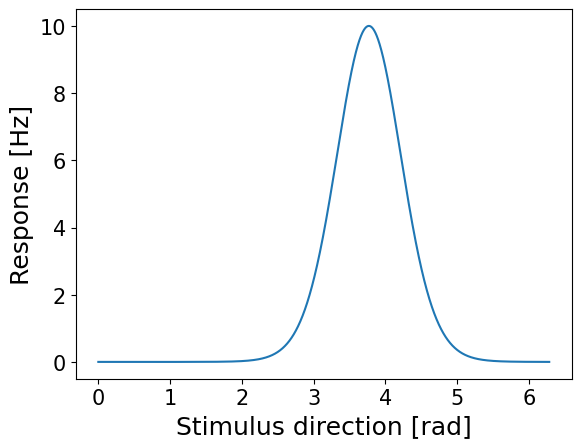

neuron ref dir 3.769911184307752
r_max: 0.01
k parameter of Von Mises curves: 5


In [10]:


N_points_function = len(X)
x_points = np.linspace(0, 2*np.pi, N_points_function)

tuning_curves = np.zeros((N_neurons, N_points_function)) #initialization

for i in range(0, N_neurons):

    pref_HD_eachneuron = neuro_pref_dir_vector[i]
    pref_dir_vector_eachneuro= pref_HD_eachneuron*np.ones_like(x_points)
    #tuning_curves[i, :] = VonMisesFunction(a,rate_depending_velocity,k,x_points,pref_HD_eachneuron)
    tuning_curves[i, :] = VonMisesFunction(a,r_max *(10**3),k,x_points,pref_HD_eachneuron)

# Plot all tuning curves
'''plt.figure(figsize=(8, 6))
for i in range(N_neurons):
    plt.plot(x_points, tuning_curves[i, :], label=f'Neuron {i+1} (Pref Dir: {neuro_pref_dir_vector[i]:.2f})')
'''
plt.figure(figsize=(6.4, 4.8))
plt.plot(x_points, tuning_curves[20], label=f'Neuron {3} (Pref Dir: {neuro_pref_dir_vector[5]:.2f})')

# Adding labels and title
plt.xlabel('Stimulus direction [rad]', fontsize = 18)
plt.ylabel('Response [Hz]', fontsize = 18)
#plt.title('Tuning Curves of Neurons')
#plt.legend()
# Set font size for tick labels
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.show()


print('neuron ref dir', neuro_pref_dir_vector[20])
print('r_max:', r_max)
print('k parameter of Von Mises curves:', k)



Deriving the rates for each time point for each neuron

In [11]:
#initialize matrix
rates_matrix = np.zeros((N_neurons, N_time_points))

theta_HD_reshaped = theta_HD.ravel()   #this is to fratten the array from 2D (21,1) to 1D (21,) because matrix_rates[n,:] is of type 1D

for n in range(0, N_neurons):
    dir_neuro = neuro_pref_dir_vector[n]
    rates_matrix[n,:] = VonMisesFunction(a,r_max,k,theta_HD_reshaped, dir_neuro)
    #rates_matrix[n,:] = VonMisesFunction(a,rate_depending_velocity,k,theta_HD_reshaped, dir_neuro)

print(1/(2*np.pi*sp.i0(k)))
print(1/k)

0.005842719970289331
0.2


Deriving the Poisson probabilities for an inhomogenous process

In [12]:
#let's create a probability graph for a certain time point t

poisson_prob_neuro = rates_matrix*dt_spikewindow

neurons = np.linspace(1,N_neurons, N_neurons)
neurons = neurons.astype(int)

#probability colormap: probability of spiking of neurons at each time step
#shortening_ticks_factor = 500
#probability_colormap(poisson_prob_neuro, T_vec, N_steps, shortening_ticks_factor, neurons)



SPIKES GENERATION

In [13]:
rng = np.random.default_rng()  # Independent random generator
seed_poiss = 54 #rng.integers(0, 2**32) 
spike_matrix_01 = inhomog_poisson_spike_gen(poisson_prob_neuro, seed_poiss)

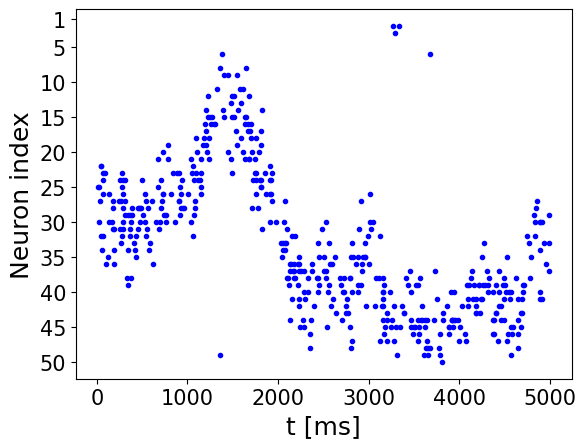

In [14]:
#let's now represent the data in a scatter plot to get an idea of the spiking locations

# Get the indices of the elements that are 1
y, x = np.where(spike_matrix_01 == 1)
#y_inverted = y[::-1]  # Reverse the order of the elements in y to match the encoding and decoding graphs
#set the ticks for the plot
shortening_ticks_factor = 500
neuron_ticks, neuron_ticks_label = set_neuron_ticks(neurons)
ticks_time_points, ticks_time_points_label = set_time_ticks(T_vec, N_steps, shortening_ticks_factor)

# Plot the points where the matrix has 1s
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.scatter(x, y, color='blue', marker='.')
ax.invert_yaxis() # Invert y-axis to match matrix indexing
ax.set_yticks(neuron_ticks)
ax.set_yticklabels(neuron_ticks_label)
#ax.set_xticks(ticks_time_points)
#ax.set_xticklabels(ticks_time_points_label)
ax.set_ylabel('Neuron index', fontsize = 18)
ax.set_xlabel('t [ms]', fontsize = 18)
ax.tick_params(axis='x', labelsize=15)  # x-axis tick labels
ax.tick_params(axis='y', labelsize=15)  # y-axis tick labels

#ax.set_title('Spikes')
#plt.show()

In [15]:
print('Total number of spikes: ', sum(sum(spike_matrix_01)))

Total number of spikes:  490


DECODING

Decoding with/without overlapping time bins and wiegthed past and present point

In [16]:
#varibles
decoding_time_interval_otb_alpha = int(50/dt_position) #int(50/dt_position)
time_overlapping_otb_alpha = int(10/dt_position)


In [17]:
#RMSE over alpha value


# Initialize results
alpha_values = np.linspace(0.01, 1.0, 50)  # Adjust range and step as needed
mse_values = []

num_bins_to_exclude_otb_alpha = decoding_time_interval_otb_alpha // time_overlapping_otb_alpha
resultant_mean_real_positions = mean_position_vector(theta_HD, time_overlapping_otb_alpha)
real_mean_HD = resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten()

mse_values_aperf = []
def ewma_circdata_alpha(alpha, data):
    
    ewma_values = []
    cos_data = np.cos(data)
    sin_data = np.sin(data)
    for t in range(0,len(data)): 
        ewma_cos_value = alpha*cos_data[t] + (1-alpha)*cos_data[t-1]
        ewma_sin_value = alpha*sin_data[t] + (1-alpha)*sin_data[t-1]
        ewma_value = np.arctan2(ewma_sin_value, ewma_cos_value)
        ewma_values.append(ewma_value)

    return ewma_values


# Loop over alpha values
for alpha in alpha_values:

    
    alpha_value = alpha


    dec_pos_overlbins_alpha_compxy, norm_rex_vector_alpha, spike_count_alpha, pop_vec= resultant_vector_overlbins_alpha(spike_matrix_01,
                                                                                                               neuro_pref_dir_vector,
                                                                                                               decoding_time_interval_otb_alpha,
                                                                                                               time_overlapping_otb_alpha,
                                                                                                               alpha_value)

    dec_pos_overlbins_alpha = np.arctan2(dec_pos_overlbins_alpha_compxy[:,1], dec_pos_overlbins_alpha_compxy[:,0]) 
    dec_pos_overlbins_alpha_02pi = dec_pos_overlbins_alpha + np.pi #so now the angles range from 0 to 2\pi

    

    res_pos_otb_alpha = -np.pi*np.ones_like(real_mean_HD) + [(dec_pos_overlbins_alpha- real_mean_HD
        + np.pi*np.ones_like(real_mean_HD)) % (2*np.pi)]

    #sum Root Squared of residuals/distances components 
    #sum_res_RS_otb_alpha_x = np.sqrt(np.sum((np.cos(res_pos_otb_alpha))**2)/(res_pos_otb_alpha.size))
    #sum_res_RS_otb_alpha_y = np.sqrt(np.sum((np.sin(res_pos_otb_alpha))**2)/(res_pos_otb_alpha.size))
    sum_res_RS_otb_alpha_x = (np.sum((np.cos(res_pos_otb_alpha))**2)/(res_pos_otb_alpha.size))
    sum_res_RS_otb_alpha_y = (np.sum((np.sin(res_pos_otb_alpha))**2)/(res_pos_otb_alpha.size))


    #Squared root of Sum Residuals Squared (SRSS)
    MSE_otb_alpha = np.arctan2(sum_res_RS_otb_alpha_y, sum_res_RS_otb_alpha_x)

    mse_values.append(MSE_otb_alpha)










In [18]:
def calculate_mse(alpha):
    # Same steps as in the for loop above, but now as a function of alpha
    dec_pos_overlbins_alpha_compxy, norm_rex_vector_alpha, spike_count_alpha, pop_vec = resultant_vector_overlbins_alpha(
        spike_matrix_01,
        neuro_pref_dir_vector,
        decoding_time_interval_otb_alpha,
        time_overlapping_otb_alpha,
        alpha
    )

    dec_pos_overlbins_alpha = np.arctan2(dec_pos_overlbins_alpha_compxy[:, 1], dec_pos_overlbins_alpha_compxy[:, 0])
    dec_pos_overlbins_alpha_02pi = dec_pos_overlbins_alpha + np.pi

    num_bins_to_exclude_otb_alpha = decoding_time_interval_otb_alpha // time_overlapping_otb_alpha
    resultant_mean_real_positions = mean_position_vector(theta_HD, time_overlapping_otb_alpha)

    res_pos_otb_alpha = -np.pi * np.ones_like(resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten()) + [
        (dec_pos_overlbins_alpha - resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten()
         + np.pi * np.ones_like(resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten())) % (2 * np.pi)]

    sum_res_RS_otb_alpha_x = (np.sum((np.cos(res_pos_otb_alpha)) ** 2) / (res_pos_otb_alpha.size))
    sum_res_RS_otb_alpha_y = (np.sum((np.sin(res_pos_otb_alpha)) ** 2) / (res_pos_otb_alpha.size))
    
    MSE_otb_alpha = np.arctan2(sum_res_RS_otb_alpha_y, sum_res_RS_otb_alpha_x)

    return MSE_otb_alpha


# Use scipy's minimize_scalar
result = minimize_scalar(calculate_mse, bounds=(0.001, 1.0), method='bounded')
best_alpha = result.x
min_mse = result.fun

print(f"The optimal alpha is {best_alpha} with a minimum MSE of {min_mse}")


The optimal alpha is 0.1895357508114157 with a minimum MSE of 0.02668450819302125


Minimum value of MSE: 0.026302722055989824
alpha values corresponding to the minimum of MSE:  0.16673346693386776


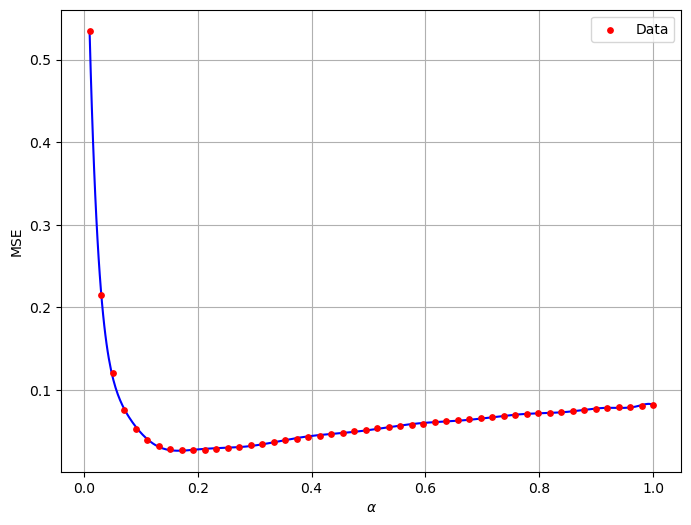

In [19]:

# Fit a polynomial of degree 2 (or adjust degree as needed)
coefficients = np.polyfit(alpha_values, mse_values, deg=15)  # Change `deg` for higher/lower order
polynomial = np.poly1d(coefficients)

# Generate fitted values
alpha_fit = np.linspace(min(alpha_values), max(alpha_values), 500)
mse_fit = polynomial(alpha_fit)

min_mse_index = np.argmin(mse_fit)  # Index of the minimum RMSE
min_mse_alpha = alpha_fit[min_mse_index]  # Corresponding alpha value

print('Minimum value of MSE:' , min(mse_fit))
print('alpha values corresponding to the minimum of MSE: ', min_mse_alpha)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(alpha_values, mse_values, color='red', label='Data', zorder=5, s=15)
#plt.scatter(alpha_values, mse_values_aperf, color='green', label='Perf dec', zorder=5, s=15)
plt.plot(alpha_fit,mse_fit , color='blue', zorder=4)
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
#plt.title('Polynomial Regression: MSE vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# save values in a csv file to use later for further plots

import os

# Ensure the output directory exists
output_dir = "alpha_plots_outputs"
os.makedirs(output_dir, exist_ok=True)

# Define the file names and corresponding data
file_data_pairs = [
("alpha_values.csv", alpha_values),
("mse_values.csv", mse_values),
("alpha_fit.csv", alpha_fit),
("mse_fit.csv", mse_fit),
("best_alpha.csv", best_alpha), 
("min_mse.csv", min_mse)
]

# Process each file and its data
for file_name, data in file_data_pairs:
    # Construct the file path dynamically
    file_path = os.path.join(output_dir, file_name)

    if not os.path.exists(file_path):
        # Initialize with experiment data (columns: Experiment_1)
        # Check if 'data' is a scalar
        if np.isscalar(data):
            # If data is a scalar, create a DataFrame with an explicit index
            df = pd.DataFrame({f"k_{k}": [data]}, index=[0])  # Explicit index
        else:
            df = pd.DataFrame({f"k_{k}": data})
            
        df.to_csv(file_path, index=False)
    else:
        # Append the new data as a new column for each experiment
        df = pd.read_csv(file_path)
        df[f"k_{k}"] = data
        df.to_csv(file_path, index=False)

(496,)
(496, 2)


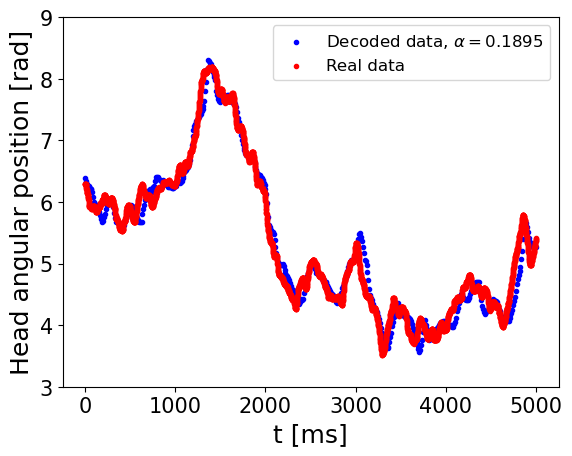

In [21]:

alpha_value = best_alpha #min_mse_alpha #0.196 * (1/dt_position) * (abs(mu_X) + 1)
# Format alpha to 4 decimal places
formatted_alpha = f"{alpha_value:.4f}"

dec_pos_overlbins_alpha_compxy, norm_rex_vector_alpha, spike_count_alpha, pop_vec= resultant_vector_overlbins_alpha(spike_matrix_01,neuro_pref_dir_vector,decoding_time_interval_otb_alpha,time_overlapping_otb_alpha,alpha_value)

dec_pos_overlbins_alpha = np.arctan2(dec_pos_overlbins_alpha_compxy[:,1], dec_pos_overlbins_alpha_compxy[:,0]) 
dec_pos_overlbins_alpha_02pi = dec_pos_overlbins_alpha + np.pi #so now the angles range from 0 to 2\pi

num_bins_to_exclude_otb_alpha = decoding_time_interval_otb_alpha // time_overlapping_otb_alpha

T_vec_intervals_otb_alpha =  np.linspace(0, T, num=(T // max(time_overlapping_otb_alpha, dt_position)) + 1 - num_bins_to_exclude_otb_alpha)
print(T_vec_intervals_otb_alpha.shape)
print(dec_pos_overlbins_alpha_compxy.shape)

fig, ax = plt.subplots(figsize=(6.4, 4.8)) #plt.subplots(figsize=(7,10))
ax.scatter(T_vec_intervals_otb_alpha, dec_pos_overlbins_alpha_02pi, color='blue', marker='.', label=f'Decoded data, $\\alpha = {formatted_alpha}$')
ax.scatter(T_vec, (theta_HD+np.pi), color='red', marker='.', label='Real data')

ax.scatter(T_vec_intervals_otb_alpha, dec_pos_overlbins_alpha_02pi + 2 * np.pi, color='blue', marker='.')
ax.scatter(T_vec, (theta_HD+ 3 * np.pi), color='red', marker='.')
#ax.invert_yaxis() # Invert y-axis to match matrix indexing
#ax.set_yticks(neuron_ticks)
#ax.set_yticklabels(neuron_ticks_label)
#ax.set_xticks(ticks_time_points)
#ax.set_xticklabels(ticks_time_points_label)
# Limit y-axis to only show values from pi to 3pi
ax.set_ylim([3,9])   #([bottom_limit, up_limit])
ax.legend(fontsize = 12)
ax.set_ylabel('Head angular position [rad]', fontsize = 18)
ax.set_xlabel('t [ms]', fontsize = 18)
ax.tick_params(axis='x', labelsize=15)  # x-axis tick labels
ax.tick_params(axis='y', labelsize=15)  # y-axis tick labels

#ax.set_title('Decoded head angular position')


(496,)
(496, 1)


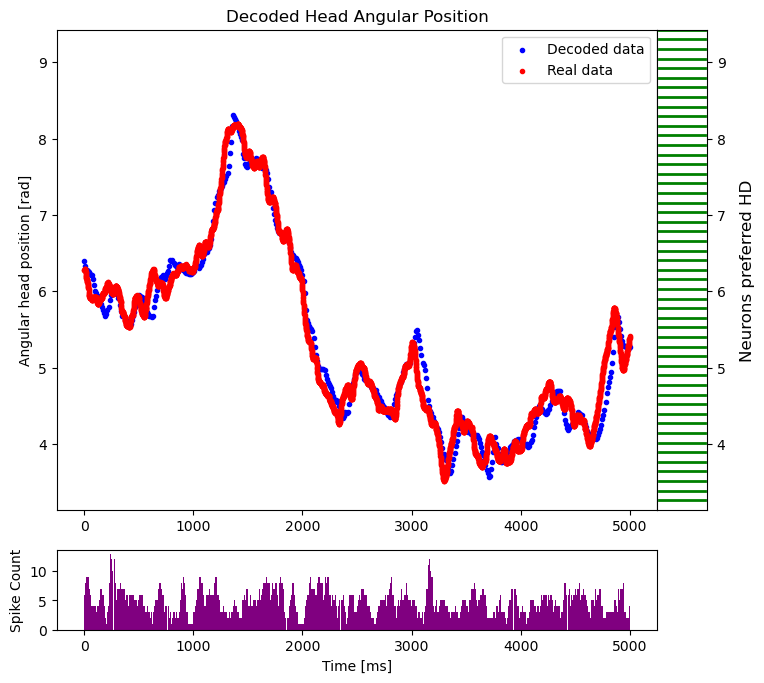

In [22]:
print(T_vec_intervals_otb_alpha.shape)
print(spike_count_alpha.shape)

# Create Main Figure and Axes
fig = plt.figure(figsize=(10, 8))

# Main Graph
ax_main = fig.add_axes([0.1, 0.2, 0.6, 0.6])  # [left, bottom, width, height]
ax_main.scatter(T_vec_intervals_otb_alpha, dec_pos_overlbins_alpha_02pi, color='blue', marker='.', label='Decoded data')
ax_main.scatter(T_vec, (theta_HD + np.pi), color='red', marker='.', label='Real data')
ax_main.scatter(T_vec_intervals_otb_alpha, dec_pos_overlbins_alpha_02pi + 2 * np.pi, color='blue', marker='.')
ax_main.scatter(T_vec, (theta_HD + 3 * np.pi), color='red', marker='.')
ax_main.set_ylim([bottom_limit, up_limit])
ax_main.set_ylabel('Angular head position [rad]')
#ax_main.set_xlabel('Time [ms]')
ax_main.legend()
ax_main.set_title('Decoded Head Angular Position')

# Right-Side Graph for Neuron Preferred Directions
ax_right = fig.add_axes([0.70, 0.2, 0.05, 0.6])  # Narrow vertical plot
# Shift for alignment
y_positions_1 = neuro_pref_dir_vector + np.pi
y_positions_2 = neuro_pref_dir_vector + 3 * np.pi

# Plot the first set (neuro_pref_dir_vector + np.pi)
for y in y_positions_1:
    ax_right.plot([0, 1], [y, y], color='green', linewidth=2)  # Line of length 1

# Plot the second set (neuro_pref_dir_vector + 3*np.pi)
for y in y_positions_2:
    ax_right.plot([0, 1], [y, y], color='green', linewidth=2)  # Line of length 1

ax_right.set_ylim(ax_main.get_ylim())
ax_right.set_xticks([])  # Hide x-axis ticks
# Show y-axis ticks on the right side
ax_right.tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True)
#ax_right.set_title('Neuron Directions', rotation='vertical', loc='center', pad=30)

# Add vertical title to the right side
fig.text(
    0.79,  # x-coordinate (right side of the plot)
    0.5,  # y-coordinate (middle of the plot)
    'Neurons preferred HD',  # Title text
    ha='center',  # Center the text horizontally
    va='center',  # Center the text vertically
    rotation=90,  # Make the text vertical
    fontsize=12  # Font size
)

# Bottom Graph for Spike Count
ax_bottom = fig.add_axes([0.1, 0.05, 0.6, 0.1])  # Short horizontal plot
ax_bottom.bar(T_vec_intervals_otb_alpha, spike_count_alpha.flatten(), width=10.0, color='purple', align='center')
ax_bottom.set_xlim(ax_main.get_xlim())
ax_bottom.set_xlabel('Time [ms]')
ax_bottom.set_ylabel('Spike Count')
# Get the max spike count for setting y-ticks
max_spike_count = np.max(spike_count_alpha)

# Set y-ticks from 0 to max_spike_count with 3 intermediate ticks
ax_bottom.set_yticks(np.arange(0, max_spike_count+1, 5))  # 5 values: 0, 2 intermediate, max

# Add a thick horizontal line at spike_count = 1
#ax_bottom.axhline(y=1, color='red', linewidth=2, linestyle='--')

plt.show()


plt.show()

RMSE  :  0.16194264483276985
RMSE over alpha  :  0.8544174074784423


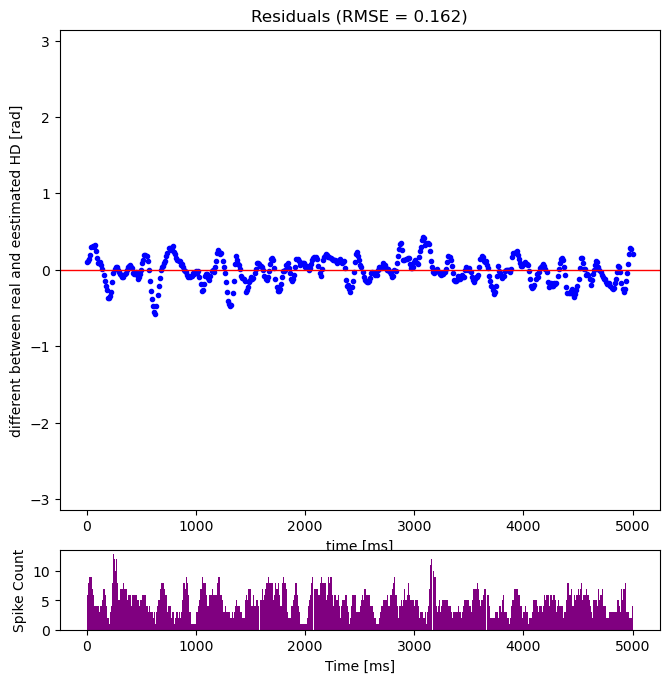

In [23]:
resultant_mean_real_positions = mean_position_vector(theta_HD, time_overlapping_otb_alpha)

res_pos_otb_alpha = -np.pi*np.ones_like(resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten()) + [
    (dec_pos_overlbins_alpha- resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten() 
     + np.pi*np.ones_like(resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten())) % (2*np.pi)]


#sum Root Squared of residuals/distances components 
sum_res_RS_otb_alpha_x = np.sqrt(np.sum((np.cos(res_pos_otb_alpha))**2)/(res_pos_otb_alpha.size))
sum_res_RS_otb_alpha_y = np.sqrt(np.sum((np.sin(res_pos_otb_alpha))**2)/(res_pos_otb_alpha.size))


#Squared root of Sum Residuals Squared (SRSS)
RMSE_otb_alpha = np.arctan2(sum_res_RS_otb_alpha_y, sum_res_RS_otb_alpha_x)

print('RMSE  : ', RMSE_otb_alpha)
print('RMSE over alpha  : ', RMSE_otb_alpha / alpha_value)


#plotting residuals

# Create Main Figure and Axes
fig = plt.figure(figsize=(10, 8))

# Main Graph
ax_main = fig.add_axes([0.1, 0.2, 0.6, 0.6])
ax_main.scatter(T_vec_intervals_otb_alpha, res_pos_otb_alpha, color='blue', marker='.', label='decoded data')
ax_main.axhline(y=0, color='red', linestyle='-', linewidth=1)
ax_main.set_ylim(-np.pi, np.pi)
ax_main.set_ylabel('different between real and eestimated HD [rad]')
ax_main.set_xlabel('time [ms]')
ax_main.set_title(f'Residuals (RMSE = {RMSE_otb_alpha:.3f})')
# Bottom Graph for Spike Count
ax_bottom = fig.add_axes([0.1, 0.05, 0.6, 0.1])  # Short horizontal plot
ax_bottom.bar(T_vec_intervals_otb_alpha, spike_count_alpha.flatten(), width=10.0, color='purple', align='center')
ax_bottom.set_xlim(ax_main.get_xlim())
ax_bottom.set_xlabel('Time [ms]')
ax_bottom.set_ylabel('Spike Count')
# Get the max spike count for setting y-ticks
max_spike_count = np.max(spike_count_alpha)

# Set y-ticks from 0 to max_spike_count with 3 intermediate ticks
ax_bottom.set_yticks(np.arange(0, max_spike_count+1, 5))  # 5 values: 0, 2 intermediate, max

# Add a thick horizontal line at spike_count = 1
#ax_bottom.axhline(y=1, color='red', linewidth=2, linestyle='--')
plt.show()



Histogram residulas-spike count

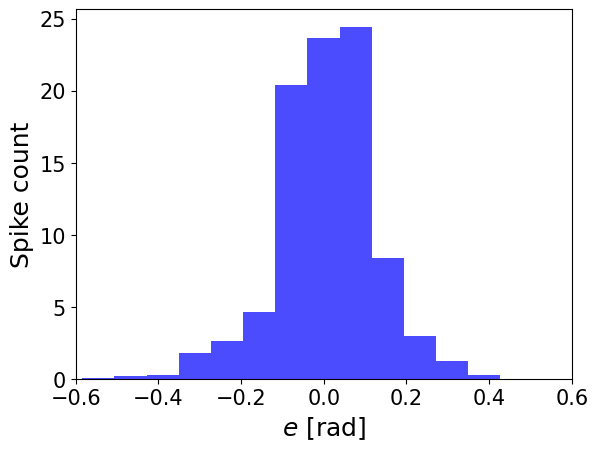

num_bins 13


In [24]:
# Flatten spike_count_alpha if needed
res_pos_otb_alpha_flat = res_pos_otb_alpha.flatten()
spike_count_alpha_flat = spike_count_alpha.flatten()

# Get the unique values in spike_count_alpha_flat
unique_values = np.unique(spike_count_alpha_flat)

# Find out how many different unique values there are
num_unique_values = len(unique_values)

# Define the number of bins
num_bins = num_unique_values

# Calculate the histogram based on spike_count_alpha_flat values
bin_counts, bin_edges = np.histogram(spike_count_alpha_flat, bins=num_bins)

points_in_bin = np.zeros(num_bins)
# Print the number of res_pos_otb_alpha_flat points in each bin
for i in range(num_bins):
    # Find the indices where spike_count_alpha_flat values fall into the current bin
    bin_indices = np.where((spike_count_alpha_flat >= bin_edges[i]) & (spike_count_alpha_flat < bin_edges[i+1]))[0]
    
    # Count how many res_pos_otb_alpha_flat points fall into the bin
    points_in_bin[i] = len(bin_indices)

    spike_count_alpha_flat[bin_indices] =  spike_count_alpha_flat[bin_indices]/points_in_bin[i]
    #spike_where = spike_where/points_in_bin[i]

# Create a histogram with spike_count_alpha_flat as weights
plt.figure(figsize=(6.4, 4.8))

# Plot the weighted histogram with res_pos_otb_alpha_flat on the x-axis and spike_count_alpha_flat as weights
plt.hist(res_pos_otb_alpha_flat, bins=num_unique_values, weights=spike_count_alpha_flat, color='blue', alpha=0.7)

# Adding titles and labels
#plt.title('Weighted Histogram between res_pos_otb_alpha and spike_count_alpha')
plt.xlabel(r'$e$ [rad]', fontsize = 18)
plt.ylabel('Spike count', fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(-0.6,0.6)
plt.show()

print('num_bins', num_bins)

MSE and OPTIMAL ALPHA varying k (parameter for Von MIses tuning curves width)

In [25]:
#Von Mises Functions parameters, VonMisesFunction(a, b, k, w, d_i)
a = 0
r_max_k= 0.01 # units [ms] #10 spikes/s peak firing rate

#initialize parameters and arrays

theta_HD_reshaped_k = theta_HD.ravel()

dec_time_interval_k = int(50/dt_position) #int(50/dt_position)
time_overl_k = int(10/dt_position)

num_bins_to_exclude_k = dec_time_interval_k // time_overl_k
mean_real_pos_k = mean_position_vector(theta_HD, time_overl_k)
mean_real_pos_k = mean_real_pos_k[:-num_bins_to_exclude_k].flatten()

# Initialize variables to store results
mse_values = []
alpha_values = []
k_values = range(1, 13)

for k in k_values:

    rates_matrix_k = np.zeros((N_neurons, N_time_points))

    #this is to fratten the array from 2D (21,1) to 1D (21,) because matrix_rates[n,:] is of type 1D

    for n in range(0, N_neurons):
        dir_neuro = neuro_pref_dir_vector[n]
        rates_matrix_k[n,:] = VonMisesFunction(a,r_max_k,k,theta_HD_reshaped_k, dir_neuro)


    poisson_prob_neuro_k = rates_matrix_k*dt_spikewindow



    seed_poiss = 54
    spike_matrix_01_k = inhomog_poisson_spike_gen(poisson_prob_neuro_k, seed_poiss)


    def calculate_mse(alpha):
        # Same steps as in the for loop above, but now as a function of alpha
        dec_pos_xy_k,_,_,_ = resultant_vector_overlbins_alpha(
            spike_matrix_01_k,
            neuro_pref_dir_vector,
            dec_time_interval_k,
            time_overl_k,
            alpha
        )

        dec_pos_k = np.arctan2(dec_pos_xy_k[:, 1], dec_pos_xy_k[:, 0])
        dec_pos_overlbins_alpha_02pi = dec_pos_k + np.pi

        

        res_pos_otb_alpha = -np.pi * np.ones_like(mean_real_pos_k) + [
            (dec_pos_k - mean_real_pos_k+ np.pi * np.ones_like(mean_real_pos_k)) % (2 * np.pi)]

        mse_x_k = (np.sum((np.cos(res_pos_otb_alpha)) ** 2) / (res_pos_otb_alpha.size))
        mse_y_k = (np.sum((np.sin(res_pos_otb_alpha)) ** 2) / (res_pos_otb_alpha.size))
        
        mse_values_k = np.arctan2(mse_y_k, mse_x_k)

        return mse_values_k


    # Use scipy's minimize_scalar
    result = minimize_scalar(calculate_mse, bounds=(0.001, 1.0), method='bounded')
    best_alpha = result.x
    min_mse = result.fun

    # Store the results
    mse_values.append(min_mse)
    alpha_values.append(best_alpha)





Correlation between decoded and real (mean) head positions

In [26]:

#return Var_x, Var_y, Cov_XY, width, height, angle
var_dec_data, var_real_pos, cov_dec_real_data, _ , _ , _ = covariance_matrix(dec_pos_overlbins_alpha,resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha])

#standard deviations for x and y 
sigma_dec_data = np.sqrt(var_dec_data)
sigma_real_pos = np.sqrt(var_real_pos)

#correlation coefficient
rho_dec_real_data = cov_dec_real_data/(sigma_dec_data*sigma_real_pos)
print(r'Correlation coeffiecient \rho : ', rho_dec_real_data)

#let's create a probability graph for a certain time point t

poisson_prob_neuro = rates_matrix*dt_spikewindow

neurons = np.linspace(1,N_neurons, N_neurons)
neurons = neurons.astype(int)

#probability colormap: probability of spiking of neurons at each time step
#shortening_ticks_factor = 500
#probability_colormap(poisson_prob_neuro, T_vec, N_steps, shortening_ticks_factor, neurons)




Correlation coeffiecient \rho :  0.7657311162477123


Resultant vector norm vs distance between real and decoded data

Correlation coeffiecient \rho :  -0.13526493939386572


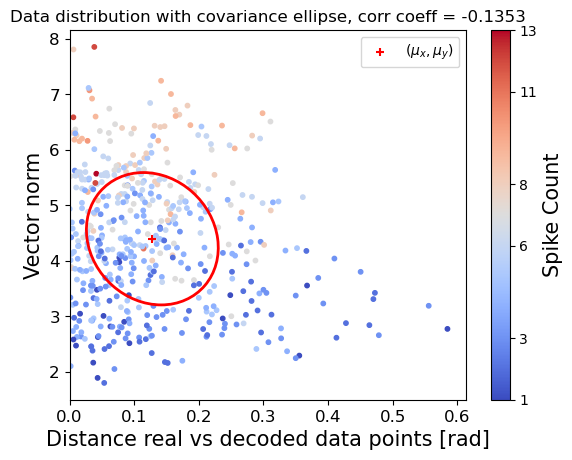

In [27]:
#overlapping time bins and exp weighted distribution

#the actual difference between real and decoded data is represented by the residuals
dist_real_dec_data_otb_alpha = np.sqrt((res_pos_otb_alpha)**2)
#dist_real_dec_data_otb_expw = np.abs(res_pos_otb_expw)
#N_points_otb_expw = norm_res_vec_otb_expw.shape[0]

mu_dist = np.mean(dist_real_dec_data_otb_alpha)
mu_norm = np.mean(norm_rex_vector_alpha)


#some statistics
var_dist, var_norm, cov_norm_dist, width_norm_dist, height_norm_dist, angle_norm_dist = covariance_matrix(dist_real_dec_data_otb_alpha,
                                                                                                          norm_rex_vector_alpha)

#standard deviations for x and y 
sigma_dist = np.sqrt(var_dist)
sigma_norm = np.sqrt(var_norm)

#correlation coefficient
rho_norm_dist_otb_expw = cov_norm_dist/(sigma_dist*sigma_norm)
print(r'Correlation coeffiecient \rho : ', rho_norm_dist_otb_expw)


# Create the plot
fig, ax = plt.subplots()

# Scatter plot of the data points
scatter =  ax.scatter(dist_real_dec_data_otb_alpha,norm_rex_vector_alpha, s=10, alpha=1,c=spike_count_alpha, cmap='coolwarm')


# Plot an ellipse that represents the covariance
ellipse = Ellipse(xy=(mu_dist,mu_norm),
                    width=width_norm_dist, height=height_norm_dist, angle=angle_norm_dist, edgecolor='red', facecolor='none', linewidth=2)
ax.add_patch(ellipse)
ax.scatter(mu_dist,mu_norm, color='red', marker='+', label=r'($\mu_x, \mu_y$)')
ax.set_xlim(left=0)
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Spike Count', fontsize = 15)
cbar.set_ticks(np.linspace(np.min(spike_count_alpha), np.max(spike_count_alpha), 6).round().astype(int))

# Labels and grid
ax.set_ylabel('Vector norm', fontsize = 15)
ax.set_xlabel('Distance real vs decoded data points [rad]', fontsize = 15)
ax.set_title("Data distribution with covariance ellipse, corr coeff = %.4f" % rho_norm_dist_otb_expw)
ax.legend()
ax.tick_params(axis='x', labelsize=12)  # x-axis tick labels
ax.tick_params(axis='y', labelsize=12)  # y-axis tick labels

#ax.grid(True)



Weighted Variance: 0.024789411279532082
Resultant weighted vector R: 0.9876882841699629
Weighted Circular Variance: 0.012311715830037095
Kappa from the fit: 41.34786336046275
maximum value for norm: 7.854751479814225


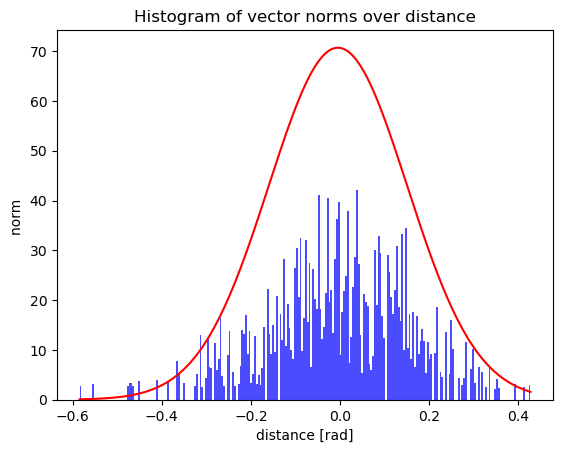

In [28]:
dist_real_dec_data_otb_alpha = res_pos_otb_alpha #np.sqrt((res_pos_otb_alpha)**2) 


#let's first normalize weigths
weights_norm = norm_rex_vector_alpha/np.sum(norm_rex_vector_alpha)

# Compute the weighted mean
weighted_mean = np.sum(dist_real_dec_data_otb_alpha.flatten() * weights_norm.flatten()) 

mean_hist = np.mean(dist_real_dec_data_otb_alpha.flatten())
# Compute the weighted variance
weighted_variance = np.sum(weights_norm.flatten() * ((dist_real_dec_data_otb_alpha.flatten() - weighted_mean)**2)) 
#weighted_variance = np.sum( ((dist_real_dec_data_otb_expw - mean_hist)**2)) / 60

print("Weighted Variance:", weighted_variance)


# Create the histogram
#plt.hist(dist_real_dec_data_otb_expw, bins=30, weights=norm_res_vec_otb_expw, alpha=0.7, color='blue', edgecolor='black')
'''counts, bins, patches = plt.hist(dist_real_dec_data_otb_alpha.flatten(), bins=60,  alpha=0.7, color='blue', edgecolor='black')
mids = 0.5*(bins[1:] + bins[:-1])
probs = counts / np.sum(counts)

mean_w_bins = np.sum(probs * mids)  
var_w_bins = np.sum(probs * (mids - mean_w_bins)**2)

print(var_w_bins)

# Add labels and title
plt.xlabel('distance')
plt.ylabel('norm / weighted counts')
plt.title('Histogram of vector norms over distance')

# Show the plot
plt.show()
'''
# Flatten arrays if not already flattened
data_dist = dist_real_dec_data_otb_alpha.flatten()
weights_norm = norm_rex_vector_alpha.flatten()


# Fit Von Mises distribution
# Compute weighted average to estimate the circular mean (mu)
mean_direction = np.arctan2(
    np.sum(weights_norm * np.sin(data_dist)),
    np.sum(weights_norm * np.cos(data_dist))
)
# Estimate concentration parameter (kappa)
R_var = np.sqrt(np.sum(weights_norm * np.cos(data_dist))**2 + np.sum(weights_norm * np.sin(data_dist))**2) / np.sum(weights_norm)
#kappa_fit = #np.mean(weights_norm) * R_var / (1 - R_var) if R_var < 1 else np.inf
kappa_fit = R_var * (2-R_var**2) / (1-R_var**2)


print(f"Resultant weighted vector R: {R_var}")
print(f"Weighted Circular Variance: {1-R_var}")
print(f"Kappa from the fit: {kappa_fit}")

print(f"maximum value for norm: {np.max(norm_rex_vector_alpha)}")
#the fact that in the histogram the maximum value is different from the above one is due to the fact that there are ultiples
#   vector norms for the same distance


# Generate a fitted distribution curve
angles_fit = np.linspace(min(data_dist), max(data_dist), 500)  # Adjust theta range for data
fitted_pdf = vonmises.pdf(angles_fit, kappa_fit, loc=mean_direction) #* len(data_dist) * np.diff(angles_fit).mean()
# Scale the PDF to match the histogram
pdf_scaled_fit  = fitted_pdf * sum(weights_norm) * (2 * np.pi / len(data_dist))
# Plot histogram and Von Mises fit
fig, ax = plt.subplots()
ax.hist(data_dist, weights=weights_norm, bins=int(data_dist.size/2), color='blue', alpha=0.7) #density = True)
ax.plot(angles_fit, pdf_scaled_fit, color='red', label='Von Mises Fit')

ax.set_xlabel('distance [rad]')
ax.set_ylabel('norm ')
ax.set_title('Histogram of vector norms over distance')
plt.show()
